In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import group_into_trips, group_by_engine_type
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
static = pd.read_csv('../VED_Static_Data_ICE_HEV.csv')
timeseries = pd.read_csv('../sample_data.csv')
ICEs, _, _, _ = group_by_engine_type(static, timeseries)

In [5]:
trips = group_into_trips(ICEs)

In [6]:
print(trips[0]['Timestamp(ms)'].head(100))
print(trips[1]['Timestamp(ms)'].head())

0         0
1       200
2      2200
3      2800
4      3000
      ...  
95    69700
96    70000
97    70700
98    71800
99    72800
Name: Timestamp(ms), Length: 100, dtype: int64
69763       0
69764     800
69765    1200
69766    1800
69767    1900
Name: Timestamp(ms), dtype: int64


In [7]:
def accel_functor():
    '''
    Return a function object that, when called with a vehicle's velocity (in km/h) 
    and a timestamp (in ms), computes the acceleration of the vehicle (in mph/s)
    based on the velocity and time of the given parameters and the parameters from
    the previous call to the function.

    The reason for the units of mph/s is for compatibility with the power factor
    formula as presented in the following paper:
    https://silo.tips/download/a-comparison-of-real-world-and-modeled-emissions-under-conditions-of-variable-dr


    This is very convenient to use with Pandas Series objects.
    For example (where trip is a DataFrame representing a trip):
    f = accel_functor()
    a = trip.apply(lambda df : f(df['Vehicle Speed[km/h]'], df['Timestamp(ms)']), axis=1)
    '''
    unit_conversion = 621.371 # from kph / ms to mph / s

    prev_v = None
    prev_t = None
    def wrapped(v, t):
        nonlocal prev_v, prev_t
        a = None
        if prev_v is not None and prev_t is not None:
            delta_v = v - prev_v # in km/h
            delta_t = t - prev_t # in ms

            a = delta_v / delta_t * unit_conversion
        prev_v = v
        prev_t = t
        return a
    return wrapped

def get_accel(trip):
    '''
    Given a trip as a Pandas DataFrame, return a Pandas Series that contains acceleration 
    data for the vehicle (in mph/s) on that trip.

    The reason for the units of mph/s is for compatibility with the power factor
    formula as presented in the following paper:
    https://silo.tips/download/a-comparison-of-real-world-and-modeled-emissions-under-conditions-of-variable-dr
    '''
    trip.sort_values(by=['Timestamp(ms)']) # this might be redundant (better safe than sorry)
    f = accel_functor()
    return trip.apply(lambda df : f(df['Vehicle Speed[km/h]'], df['Timestamp(ms)']), axis=1)

def power_factor(trip):
    '''
    Given a trip as a Pandas DataFrame and acceleration as a Pandas Series, return power
    factor data for the trip as a Pandas Series.
    '''
    trip.sort_values(by=['Timestamp(ms)']) # this might be redundant (better safe than sorry)
    return trip.apply(lambda df : 2 * df['Vehicle Speed[km/h]'] * df['Acceleration[mph/s]'], axis=1)

def aggressivity(power_factors):
    '''
    Given a timeseries of power factors as a pandas Series, return the aggressivity of the trip
    '''
    return np.sqrt(np.sum(power_factors ** 2) / len(power_factors)) 


In [8]:
trip = trips[0]
accel = get_accel(trip)
trip['Acceleration[mph/s]'] = accel
pf = power_factor(trip)
print(pf.head())
print(aggressivity(pf))

0          NaN
1   -571.66132
2     31.06855
3      0.00000
4      0.00000
dtype: float64
311.8196681425237


In [9]:
aggressivities = []
for trip in trips:
    accel = get_accel(trip)
    trip['Acceleration[mph/s]'] = accel
    pf = power_factor(trip)
    aggressivity_score = aggressivity(pf)
    aggressivities.append(aggressivity_score)
    veh_id = trip['VehId'].unique()[0]
    trip_id = trip['Trip'].unique()[0]

    print(f"VehId: {veh_id}, TripId: {trip_id} aggressivity: {aggressivity_score}")

VehId: 12, TripId: 976 aggressivity: 311.8196681425237
VehId: 463, TripId: 976 aggressivity: 440.08971449064086
VehId: 12, TripId: 977 aggressivity: 559.2446962825351
VehId: 12, TripId: 978 aggressivity: 375.5290010826952
VehId: 12, TripId: 979 aggressivity: 347.66139176013803
VehId: 463, TripId: 979 aggressivity: 268.507410768395
VehId: 12, TripId: 983 aggressivity: 428.3292776135361
VehId: 108, TripId: 1721 aggressivity: 272.2404888287852
VehId: 135, TripId: 2242 aggressivity: 307.9865127151527
VehId: 462, TripId: 2242 aggressivity: 257.84790970831006
VehId: 135, TripId: 2243 aggressivity: 356.04882297502866
VehId: 502, TripId: 2243 aggressivity: 157.44874779461583
VehId: 145, TripId: 1526 aggressivity: 510.03994236898404
VehId: 145, TripId: 1532 aggressivity: 373.7020352625076
VehId: 145, TripId: 1539 aggressivity: 546.4225615368092
VehId: 145, TripId: 1545 aggressivity: 375.3797830102769
VehId: 148, TripId: 1628 aggressivity: 304.80456156489396
VehId: 154, TripId: 2681 aggressivity

KeyboardInterrupt: 

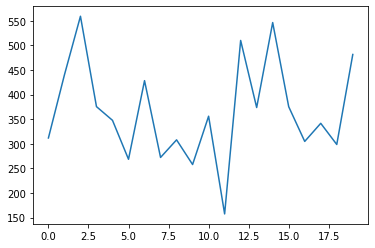

In [11]:
plt.plot(aggressivities[:20])

In [18]:
for x in range(len(trips)):
    print(trips[x]['MAF[g/sec]']).isna().unique()

0        3.56
1        3.59
2       22.18
3       22.18
4       22.18
        ...  
1062    27.26
1063    27.26
1064    27.26
1065    28.84
1066    28.84
Name: MAF[g/sec], Length: 1067, dtype: float64


AttributeError: 'NoneType' object has no attribute 'isna'